# Lab 3 : Deep Learning : Chient vs Chat

Nous allons développer un programme de vision par ordinateur pour reconnaître une photo de chat ou de chien

Donc ce qu'on aimerait faire, ça serait de fournir des photos de chats et de chiens à notre code pour qu'ils nous retourne un modèle qui soit capable de classer ce genre de photos. 

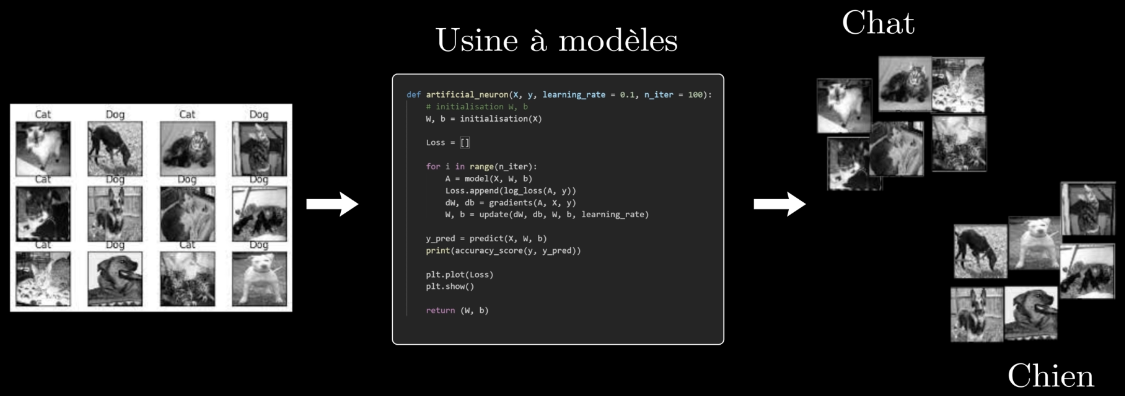

Alors pour ça dans, la dernière leçon je vous ai donné un DataSet à télécharger sur github. 
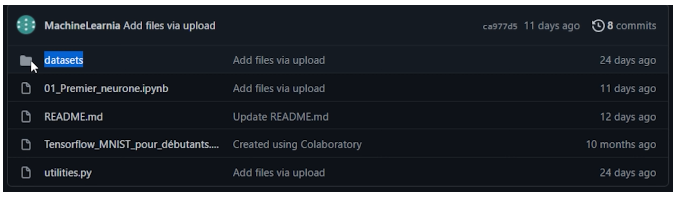

Ensuite, installer le module **h5py** qui nous permet d'ouvrir des fichiers au format **hdf5**, un format très utilisé en Deep Learning. 

In [1]:
!pip install h5py

Et tout ça nous donne alors un **trainset et un testset** qui sont composés de tableau **Numpy**. Dans le trainset, nous avons mille photos et chaque photo faisant 64 pixels par 64 pixels. 

In [2]:
from utilities import *

X_train, y_train, X_test, y_test = load_data()

In [3]:
print (X_train.shape)
print (y_train.shape)
print (np.unique(y_train,return_counts=True))

(1000, 64, 64)
(1000, 1)
(array([0., 1.]), array([500, 500], dtype=int64))


In [4]:
print (X_test.shape)
print (y_test.shape)
print (np.unique(y_test,return_counts=True))

(200, 64, 64)
(200, 1)
(array([0., 1.]), array([100, 100], dtype=int64))


C:\Users\romeofr\anaconda3\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


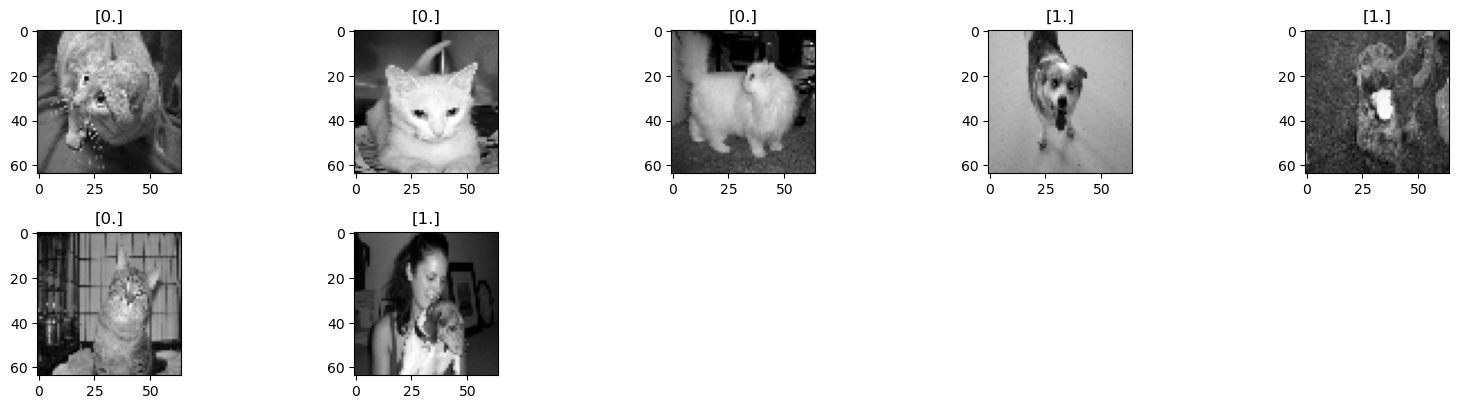

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
for i in range (1,8):
    plt.subplot(4,5,i)
    plt.imshow(X_train[i],cmap='gray')
    plt.title(y_train[i])
    plt.tight_layout()
plt.show()

### Entrainement du modèle

In [6]:
import artificial_neuron
from importlib import reload

reload(artificial_neuron)

from artificial_neuron import *

model = artificial_neuron()

X_train_reshape = X_train.reshape(X_train.shape[0], -1)
X_test_reshape = X_test.reshape(X_test.shape[0], -1)

In [7]:
model = artificial_neuron()
model.fit_light(X_train_reshape, y_train)

  0%|          | 0/1000 [00:00<?, ?it/s]F:\PY\CODE\artificial_neuron.py:23: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))
F:\PY\CODE\artificial_neuron.py:23: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))
  1%|          | 11/1000 [00:00<00:21, 45.68it/s]F:\PY\CODE\artificial_neuron.py:23: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))
  2%|▏         | 22/1000 [00:00<00:21, 45.74it/s]F:\PY\CODE\artificial_neuron.py:23: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))
  3%|▎         | 32/1000 [00:00<00:22, 42.15it/s]F:\PY\CODE\artificial_neuron.py:23: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))
  4%|▍         | 42/1000 [00:01<00:25, 38.21it/s]F:\PY\CODE\artificial_neuron.py:23: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))
  5%|▌         | 51/1000 [00:01<00:24, 38.55it/s]F:\PY\CODE\artificial_neuron.py:23: RuntimeWarning: ove

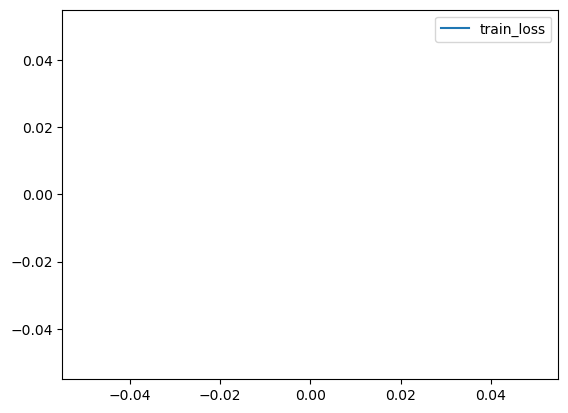

In [8]:
model.display_loss_light()

Alors de ce qu'on voit ici, le modèle n'a pas appris grand chose à son apprentissage. Il a plutôt été chaotique et ça c'est en fait lié au fait que nous avons toujours notre erreur d'overflow. Parce que on a beau avoir modifié la fonction coût en rajoutant le epsilon dans le logarithme, cela ne change rien au fait que nous ayons toujours des valeurs $Z$ qui soit trop grande et qui par extension crée un  overflow dans notre exponentielle. 

Donc pour corriger ce problème, nous allons devoir effectuer une des opérations les plus importantes du monde du Deep Learning et du machine learning. Ccelle de normaliser nos données. 

### Expérience de normalisation

dimensions de X: (100, 2)
dimensions de y: (100, 1)


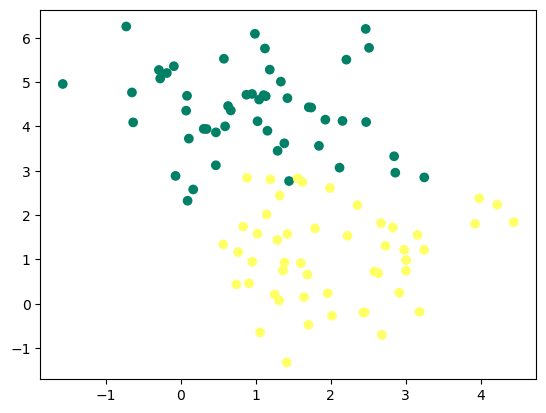

In [9]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, n_features= 2, centers=2, random_state=0)
y = y.reshape((y.shape[0], 1))


print('dimensions de X:', X.shape)
print('dimensions de y:', y.shape)

plt.scatter (X[:,0], X[:, 1], c=y, cmap='summer')
plt.show()

In [10]:
lim = 10
h=100

w1 = np.linspace(-lim, lim, h)
w2 = np.linspace(-lim, lim, h)


In [11]:
w11, w22 = np.meshgrid(w1, w2)

Donc ça nous donne un tableau $w_{11}$ qui est de dimension (100,100) puisque le vecteur $W$ à a été recopiées en boucle pour couvrir la dimension du vecteur $w_2$ est ce la même chose donc pour $w_{22}$. 

Alors nous ce qu'on voudrait faire, ça serait de passé cette grille de valeur qui donc contient dix mille configurations possibles puisque 100 x 100 ça fait dix mille. On aimerait passer ces 10000 configuration dans notre fonction $Z(x_1, x_2)$,  $z=x \cdot \operatorname{dot}(w)+b$  avec $b$ qu'on va initialiser à zéro, on le changera peut-être après car ce qui nous intéresse c'est $W$

Rappelons-nous juste que $W$ devra être de dimension $(n,10000)$ puisqu'on veut 10000 configurations possibles et $n=2$  car on a deux variables. 

Donc,  c'est ce qu'il nous faut en dimensions pour $W$, comme ça on peut effectuer le produit matricielle avec $X$ qui lui est de dimension (100,2). On a un produit matricielle entre $(100,2) \times (2,10000)$ $(X . W)$

Alors le problème, c'est qu'à l'heure actuelle nous n'avons pas un seul $W$ qui fait (2,10000), mais nous avons deux tableaux $W$ qui font chacun $100 \times 100$

Alors ce qu'on va faire, c'est qu'on va créer une variable  $W_{finale}$ qui est égal à la concaténation des deux tableaux $w_{11}$ et $w_{22}$. On va aussi aplatir chaque tableau, du coût ça nous donne 10000 valeurs dans $w_{11}$ et 10000 valeurs dans $w_{22}$. Donc on obtient un tableau de dimension (10000,2)

In [12]:
W_final = np.c_[w11.ravel(), w22.ravel()]
W_final.shape

(10000, 2)

Donc, on va transposer ce tableau, car on veut un $W$ de dimension (2,10000). 

In [13]:
W_final = np.c_[w11.ravel(), w22.ravel()].T
W_final.shape

(2, 10000)

Donc, on a créé un tableau de paramètres qui contient 10000 configurations possibles c'est à dire lorsque $W_{11}$ vaut -10  et que $W_{22}$ vaut -10 puis que $W_{11}$ vaut -10 et que $W_{22}$ vaut -9,9 etc...

Ca nous donne 10000 situations possibles et chacune de ces situations on va les évaluer. 

Donc, on va créer des prédictions,  

In [14]:
b = 0
Z = X.dot(W_final) + b
A = 1 / (1 + np.exp(-Z))

In [15]:
epsilon = 1e-15
L =  (1 / len(y)) *  (np.sum(-y * np.log(A + epsilon) - (1 - y) *  np.log(1 - A + epsilon)))
L

82387.12808750737

Et ça va nous donner un nombre réel mais ce n'est pas qu'on veut faire nous on veut obtenir 10000 coût différent puisqu'on test 100 valeur de $w_1$ et 100 valeurs de $w_2$. Donc ça nous donne 10000 configurations différentes. 

Donc, on va faire la somme en suivant un axe bien précis, l'axe=0. 

In [16]:
L =  (1 / len(y)) *  (np.sum(-y * np.log(A + epsilon) - (1 - y) *  np.log(1 - A + epsilon), axis=0))
L.shape

(10000,)

Donc cette fois ci $L$ va donc être de dimension (10000,). C'est bien et on veut afficher tout ça dans un graphique en 2d, une sorte de **contourplot** , donc on va le redimensionner en (100,100) où ce qu'on pourrait même faire c'est prendre directement les dimensions qu'on avait pour $w_{11}$

In [17]:
L =  1 / len(y) *  np.sum(-y * np.log(A + epsilon) - (1 - y) *  np.log(1 - A + epsilon), axis=0).reshape(w11.shape)
L.shape

(100, 100)

Et voilà, ça nous  donne donc un tableau $L$ à deux dimensions. Donc ce tableau, il ne reste plus qu'à l'afficher. 
Donc ça c'est pour les axes $X$ et $y$ et pour la hauteur du graphique c'est à dire les valeurs que l'on affiche sur l'axé $Z$, ça va tout simplement être $L$

#### Visualisation des résultats de la Normalisation

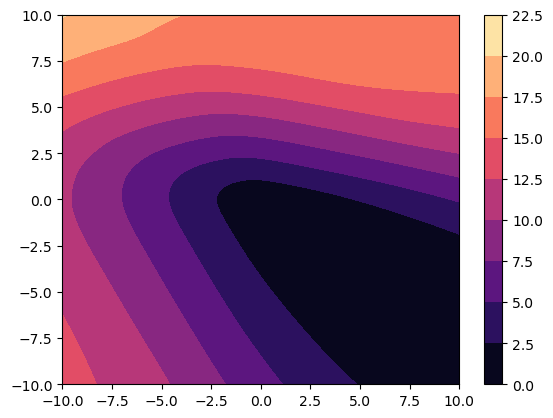

In [18]:
plt.contourf(w11, w22, L, cmap='magma')
plt.colorbar()

On voit donc l'évolution de notre fonction coût en fonction des valeurs des différents paramètres. Donc si $w_1$ vaut -7,5 et que $w_2$ vos -2,5 on aurait un coût aux alentours de 7,5-10. 

Notre objectif c'était de faire un graphique qui puisse démontrer que lorsqu'une variable devient trop imposante et bien ce graphique comment ça se compresser. 

Alors pour ça, on va prendre une de nos deux variables par exemple la variable $x_2$ et on va là multiplié par deux. 

#### Visualisation des résultats de la Normalisation * 2

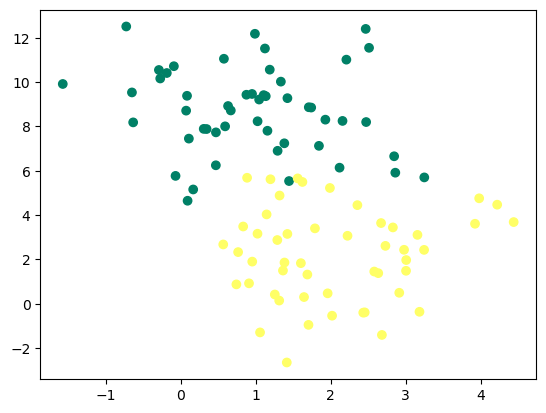

In [19]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, n_features= 2, centers=2, random_state=0)
X[:, 1]= X[:, 1] * 2

y = y.reshape((y.shape[0], 1))

plt.scatter (X[:,0], X[:, 1], c=y, cmap='summer')
plt.show()

In [20]:
lim = 10
h=100

w1 = np.linspace(-lim, lim, h)
w2 = np.linspace(-lim, lim, h)

In [21]:
w11, w22 = np.meshgrid(w1, w2)

In [22]:
W_final = np.c_[w11.ravel(), w22.ravel()].T
W_final.shape

(2, 10000)

In [23]:
b = 0
Z = X.dot(W_final) + b
A = 1 / (1 + np.exp(-Z))

In [24]:
epsilon = 1e-15
L =  1 / len(y) *  np.sum(-y * np.log(A + epsilon) - (1 - y) *  np.log(1 - A + epsilon), axis=0).reshape(w11.shape)
L.shape

(100, 100)

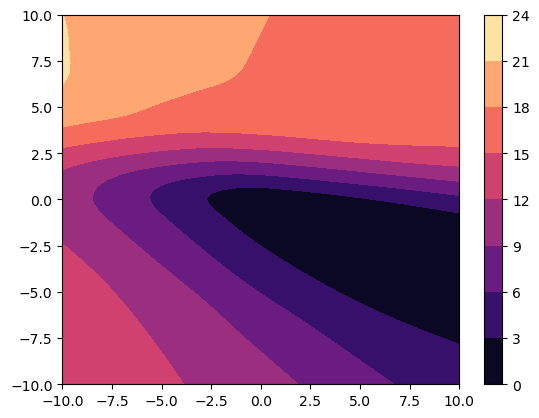

In [25]:
plt.contourf(w11, w22, L, cmap='magma')
plt.colorbar()

Vous voyez notre fonction coûts commencent à être compressé. Alors rien de très grave sauf que là, nous avons simplement multiplié par 2 notre variable $x_2$.  Voyons ce qui se passe quand on l'a multiplie par par 10,

#### Visualisation des résultats de la Normalisation * 10

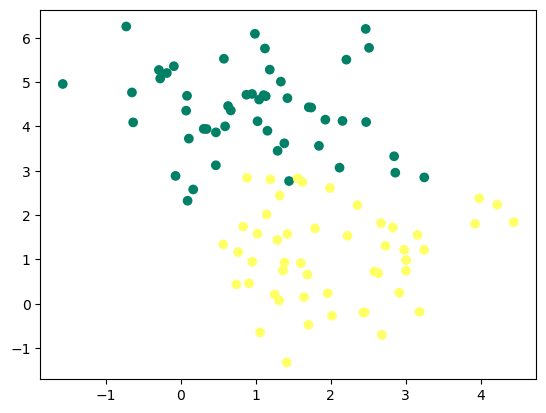

In [26]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, n_features= 2, centers=2, random_state=0)
X[:, 1]= X[:, 1] * 1

y = y.reshape((y.shape[0], 1))

plt.scatter (X[:,0], X[:, 1], c=y, cmap='summer')
plt.show()

In [27]:
lim = 10
h=100

w1 = np.linspace(-lim, lim, h)
w2 = np.linspace(-lim, lim, h)

In [28]:
w11, w22 = np.meshgrid(w1, w2)

In [29]:
W_final = np.c_[w11.ravel(), w22.ravel()].T
W_final.shape

(2, 10000)

In [30]:
b = 0
Z = X.dot(W_final) + b
A = 1 / (1 + np.exp(-Z))

In [31]:
epsilon = 1e-15
L =  1 / len(y) *  np.sum(-y * np.log(A + epsilon) - (1 - y) *  np.log(1 - A + epsilon), axis=0).reshape(w11.shape)
L.shape

(100, 100)

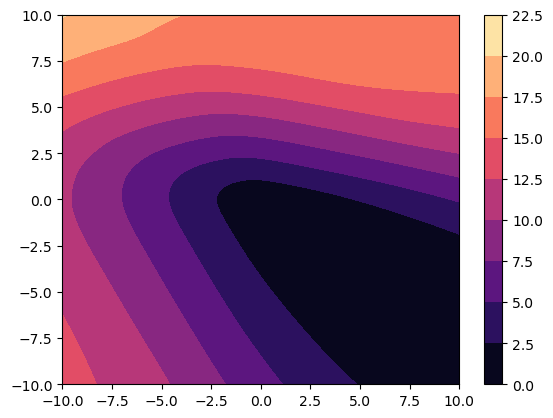

In [32]:
plt.contourf(w11, w22, L, cmap='magma')
plt.colorbar()

Et bien dans ce cas de figure le paramètre qui sera associé à la variable la plus imposante va venir complètement écrasé nos sorties ce qui fait qu'on obtient une fonction coût complètement compressé et parce que cette fonction coût est compressé de cette manière et bien notre algorithme de descente de gradient va avoir du mal à converger pour trouver le minimum et ça va nous donner une situation de zig zag comme ce qu'on avait observé tout à l'heure.

#### Visualisation de la Descente de Gradients

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [34]:
def initialisation(X):
    W = np.random.randn(X.shape[1],1)
    b = np.random.randn(1)
    return (W, b)

In [35]:
def model(X,W,b):
    Z = X.dot(W) + b
    A = 1 /     (1 + np.exp(-Z)) 
    return A

In [36]:
def log_loss(y, A):
    epsilon = 1e-15
    return 1 / len(y) *  np.sum(-y * np.log(A + epsilon) - (1 - y) *  np.log(1 - A + epsilon))

In [37]:
def gradients (A, X, y):
    dw = 1 / len(y) * np.dot(X.T, A - y)
    db = 1 / len(y) * np.sum(A - y)
    return (dw, db)

In [38]:
def update (dW, db, W, b, learning_rate):
    W = W - learning_rate * dW
    b = b - learning_rate * db
    return (W, b)

In [39]:
def predict(X, W, b):
    A = model(X, W, b)
    print(A)
    return A >= 0.5

In [40]:
def artificial_neuron_2(X, y, learning_rate=0.1, nbr_iter=1000):
    #initialisation W, b
    W, b = initialisation (X)
    W[0], W[1] = -7.5, -7.5
    
    nb = 10
    j = 0
    history = np.zeros((nbr_iter // nb, 5))    
    loss=[]
    
    for i in range(nbr_iter):
        A = model(X, W, b)
        loss.append(log_loss(y, A))
        dW, db = gradients(A, X, y)
        W, b = update(dW, db, W, b, learning_rate)
        
        if (i % nb == 0):
            history[j, 0] = W[0]
            history[j, 1] = W[1]
            history[j, 2] = b
            history[j, 3] = i
            history[j, 4] = log_loss (y, A)
            j += 1  
    
    plt.plot(loss)
    plt.show()
    
    return history, b

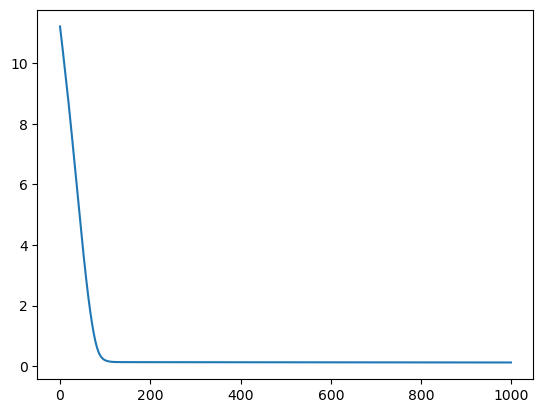

In [41]:
history, b = artificial_neuron_2(X,y)

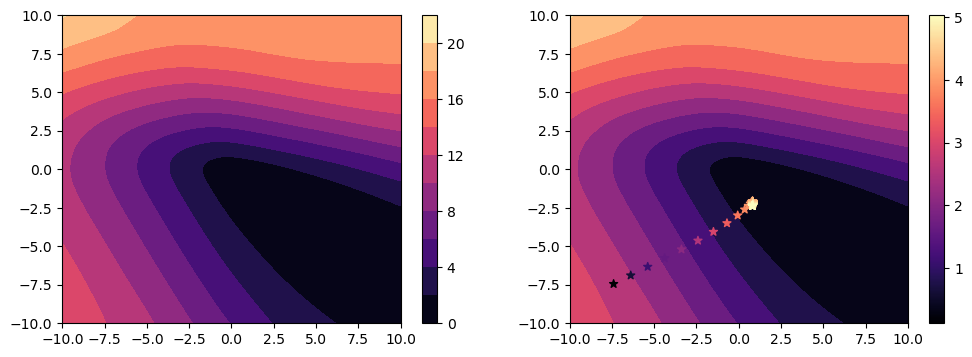

In [42]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.contourf(w11, w22, L, 10, cmap='magma')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.contourf(w11, w22, L, 10, cmap='magma')
plt.scatter(history[:, 0], history[:, 1], c=history[:, 2], cmap='magma', marker='*')
plt.colorbar()

#### Visualisation 3D

In [43]:
import plotly.graph_objects as go

fig = (go.Figure(data=[go.Surface(z=L, x=w11, y=w22, opacity = 1)]))

fig.update_layout(template = "plotly_dark", margin=dict(l=0, r=0, b=0, t=0))
fig.layout.scene.camera.projection.type = "orthographic"
fig.show()

In [44]:
X_train_reshape = X_train.reshape(X_train.shape[0], -1) / X_train.max() # (1000, 4096)
X_train_reshape.max()

1.0

In [45]:
X_test_reshape = X_test.reshape(X_test.shape[0], -1) / X_train.max() # (1000, 4096)
X_test_reshape.max()

1.0

In [46]:
from artificial_neuron import *

model = artificial_neuron()
model.fit(X_train_reshape, y_train, X_test_reshape, y_test)

100%|██████████| 1000/1000 [00:04<00:00, 229.31it/s]


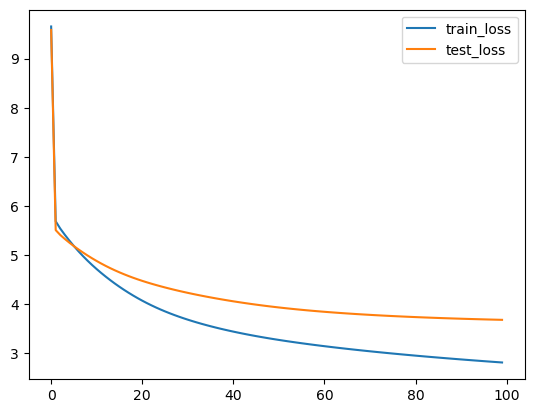

In [47]:
model.display_loss()

Alors certes nous avons toujours un graphique un petit peu étrange, mais celui ci on va laisser de côté juste un instant pour conclure sur cette histoire d'overflow car quand on y réfléchit bien tout ce qu'on vient de faire cette extrêmement logique. Rappelez-vous, si on avait un overflow c'est parce que les valeurs de $Z$ était beaucoup trop importante. On avait des valeurs de $Z$ qui valait parfois 10000 parfois 100000 parfois -50000, bref des choses beaucoup trop importante pour être passée dans une fonction exponentielle. 

Mais quand on y pense, c'était assez logique d'obtenir des valeurs aussi importante car rappelez-vous $Z$ c'est en fait égal à $w_1 x_1 + w_2x_2 + w_3 x_3$ etc... jusqu'à $w_{4096}x_{4096}$ car ici nous avons 4096 variable. 


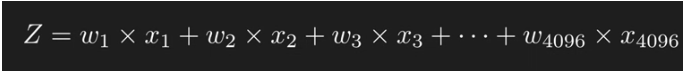

Donc si chacune de ces variables peut valoir quelque chose entre 0 et 255 mais ça fait complètement explosé la valeur de $Z$ . 

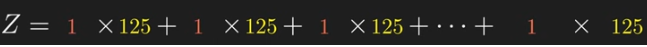

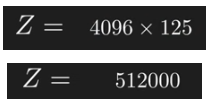

Et c'est donc là que notre problème se voit totalement résolue lorsqu'on normalise nos données car cette fois ci tout est compris entre 0 et 1. Tout ça fait que la valeur de $Z$ est fortement atténuée. 


On voit que le problème est complètement résolu, enfin il nous reste toujours ce graphique. Mais celui ci n'a aucun rapport avec la normalisation, il a en fait un lien avec les hyper paramètres de notre modèle.

#### Réglage des hyper-paramètres

Comment ça se fait qu'on obtienne toujours un graphique aussi décevant. Après tout, nous avons normalisé nos données, ce qui fait que notre fonction coût évolue progressivement et on retrouve pas de falaise à l'intérieur, alors pourquoi? Et bien, on a beau avoir une fonction coûts qui évolue progressivement, si notre algorithme de descente de gradient décide de faire des pas beaucoût trop grand dans cette fonction coût, et bien, il va oscillé et faire des va et vient 

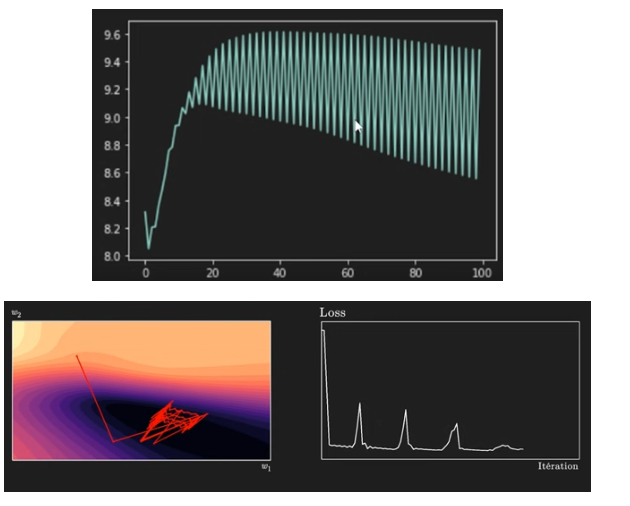

c'est peut-être ça le problème, après tout on va définir un learning_rate peut-être égal à 0,01, car de base celui ci a été réglée sur 0,1, c'est un learning_rate  beaucoup trop grand pour un vrai problème

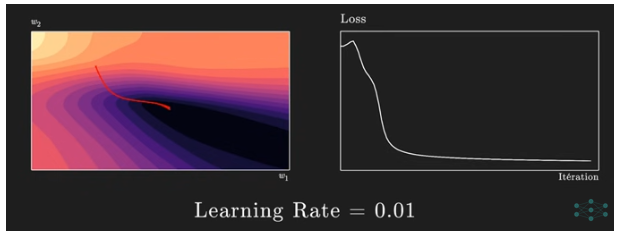

Ca fonctionne bien sur un petit dataset, sur un vrai problème avec des photos, vaut mieux passer aux choses sérieuses.

In [48]:
import artificial_neuron
from importlib import reload

reload(artificial_neuron)

from artificial_neuron import *

model = artificial_neuron(n_iter=10000, learning_rate=0.01)
model.fit(X_train_reshape, y_train, X_test_reshape, y_test)

100%|██████████| 10000/10000 [00:41<00:00, 240.64it/s]


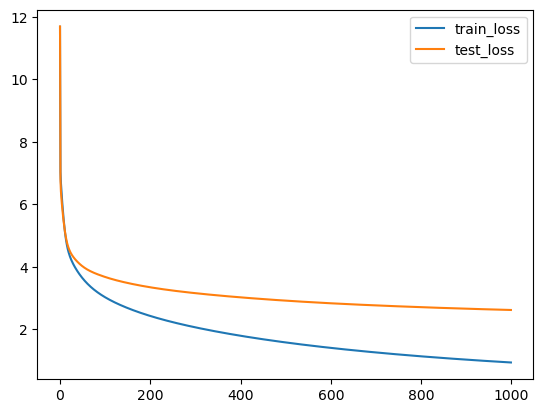

In [49]:
model.display_loss()

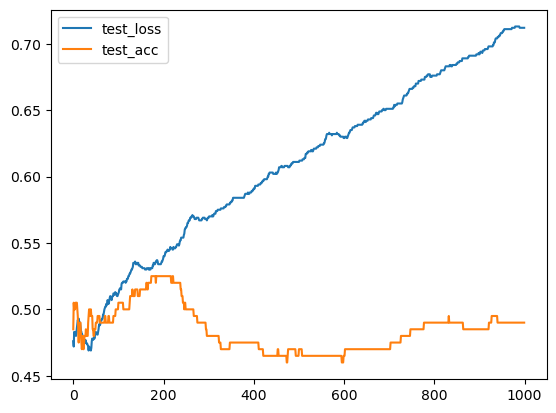

In [50]:
model.display_acc()